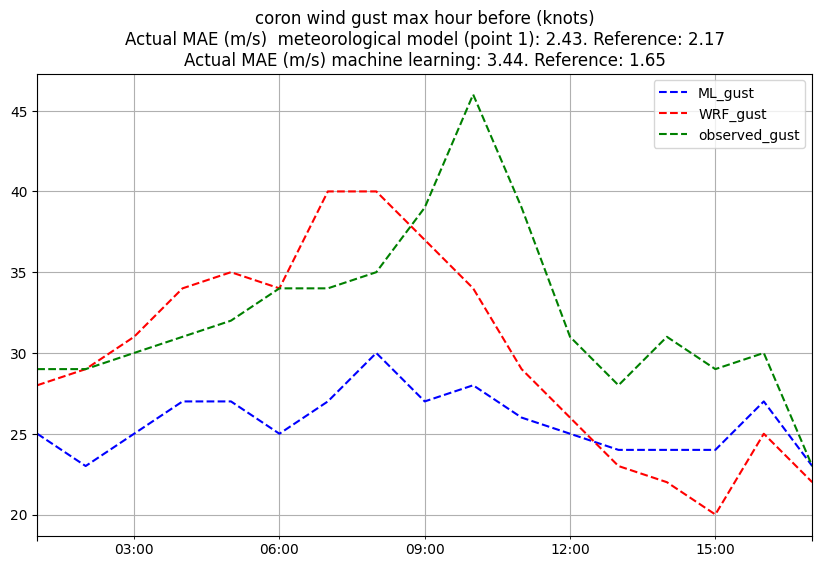

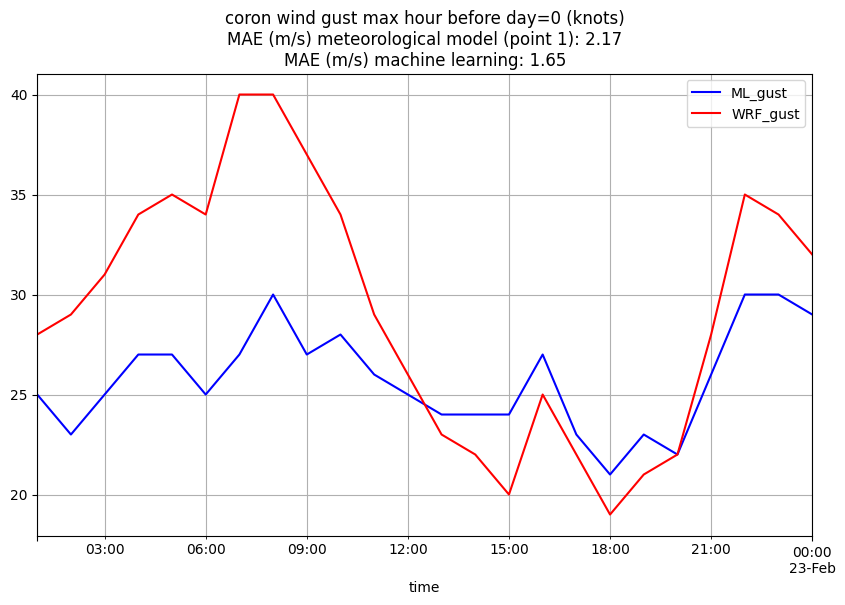

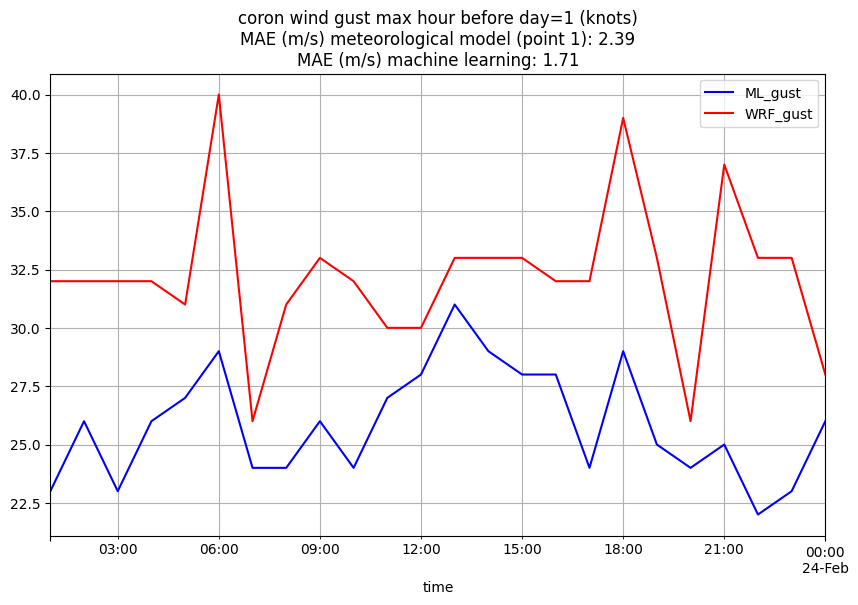

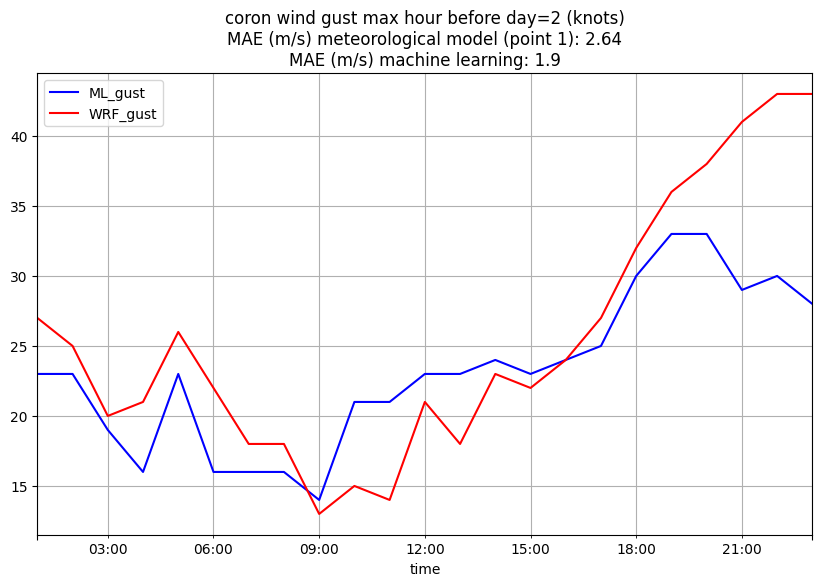

In [1]:
#@title Wind gust
station_name = "coron" # @param ["marin", "udra", "ons","coron"]
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import matplotlib.pyplot as plt
import requests
import json
import plotly.express as px
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
from sklearn.metrics import accuracy_score
import sklearn

def get_wind(st_id):
  #get actual des dir
  des_dir = requests.get("https://servizos.meteogalicia.gal/mgrss/observacion/ultimos10minEstacionsMeteo.action?idEst="+st_id+"&idParam=DV_SD_10m")
  json_data = json.loads(des_dir.content)
  instant = json_data['listUltimos10min'][0]['instanteLecturaUTC']
  des_dir = json_data['listUltimos10min'][0]['listaMedidas'][0]['valor']

  #get actual dir
  dir = requests.get("https://servizos.meteogalicia.gal/mgrss/observacion/ultimos10minEstacionsMeteo.action?idEst="+st_id+"&idParam=DV_AVG_10m")
  json_data = json.loads(dir.content)
  dir = json_data['listUltimos10min'][0]['listaMedidas'][0]['valor']

  #get actual mod
  mod = requests.get("https://servizos.meteogalicia.gal/mgrss/observacion/ultimos10minEstacionsMeteo.action?idEst="+st_id+"&idParam=VV_AVG_10m")
  json_data = json.loads(mod.content)
  mod = json_data['listUltimos10min'][0]['listaMedidas'][0]['valor']*1.94384

  #get actual des mod
  des_mod = requests.get("https://servizos.meteogalicia.gal/mgrss/observacion/ultimos10minEstacionsMeteo.action?idEst="+st_id+"&idParam=VV_SD_10m")
  json_data = json.loads(des_mod.content)
  des_mod = json_data['listUltimos10min'][0]['listaMedidas'][0]['valor']*1.94384

  return instant, dir, des_dir,mod, des_mod





def get_meteogalicia_model_4Km(coorde):
    """
    get meteogalicia model (4Km) from algo coordenates
    Returns
    -------
    dataframe with meteeorological variables forecasted.
    """

    #defining url to get model from Meteogalicia server
    today=pd.to_datetime("today")

    try:

      head1="http://mandeo.meteogalicia.es/thredds/ncss/modelos/WRF_HIST/d03"
      head2=today.strftime("/%Y/%m/wrf_arw_det_history_d03")
      head3=today.strftime("_%Y%m%d_0000.nc4?")
      head=head1+head2+head3

      var1="var=dir&var=mod&var=wind_gust&var=mslp&var=temp&var=rh&var=visibility&var=lhflx"
      var2="&var=lwflx&var=conv_prec&var=prec&var=swflx&var=shflx&var=cape&var=cin&var=cfh&var=T850"
      var3="&var=cfl&var=cfm&var=cft&var=HGT500&var=HGT850&var=T500&var=snow_prec&var=snowlevel"
      var=var1+var2+var3

      f_day=(today+timedelta(days=3)).strftime("%Y-%m-%d")
      tail="&time_start="+today.strftime("%Y-%m-%d")+"T01%3A00%3A00Z&time_end="+f_day+"T23%3A00%3A00Z&accept=csv"

      dffinal=pd.DataFrame()
      for coor in list(zip(coorde.lat.tolist(),coorde.lon.tolist(),np.arange(0,len(coorde.lat.tolist())).astype(str))):
          dffinal=pd.concat([dffinal,pd.read_csv(head+var+"&latitude="+str(coor[0])+"&longitude="+str(coor[1])+tail,).add_suffix(str(coor[2]))],axis=1)


      #filter all columns with lat lon and date
      dffinal=dffinal.filter(regex='^(?!(lat|lon|date).*?)')

      #remove column string between brakets
      new_col=[c.split("[")[0]+c.split("]")[-1] for c in dffinal.columns]
      for col in zip(dffinal.columns,new_col):
          dffinal=dffinal.rename(columns = {col[0]:col[1]})

      dffinal=dffinal.set_index(pd.date_range(start=today.strftime("%Y-%m-%d"), end=(today+timedelta(days=4)).strftime("%Y-%m-%d"), freq="H")[1:-1])

    except:

      today  = pd.to_datetime("today")-timedelta(1)
      head1="http://mandeo.meteogalicia.es/thredds/ncss/modelos/WRF_HIST/d03"
      head2=today.strftime("/%Y/%m/wrf_arw_det_history_d03")
      head3=today.strftime("_%Y%m%d_0000.nc4?")
      head=head1+head2+head3

      var1="var=dir&var=mod&var=wind_gust&var=mslp&var=temp&var=rh&var=visibility&var=lhflx"
      var2="&var=lwflx&var=conv_prec&var=prec&var=swflx&var=shflx&var=cape&var=cin&var=cfh&var=T850"
      var3="&var=cfl&var=cfm&var=cft&var=HGT500&var=HGT850&var=T500&var=snow_prec&var=snowlevel"
      var=var1+var2+var3

      f_day=(today+timedelta(days=3)).strftime("%Y-%m-%d")
      tail="&time_start="+today.strftime("%Y-%m-%d")+"T01%3A00%3A00Z&time_end="+f_day+"T23%3A00%3A00Z&accept=csv"

      dffinal=pd.DataFrame()
      for coor in list(zip(coorde.lat.tolist(),coorde.lon.tolist(),np.arange(0,len(coorde.lat.tolist())).astype(str))):
          dffinal=pd.concat([dffinal,pd.read_csv(head+var+"&latitude="+str(coor[0])+"&longitude="+str(coor[1])+tail,).add_suffix(str(coor[2]))],axis=1)


      #filter all columns with lat lon and date
      dffinal=dffinal.filter(regex='^(?!(lat|lon|date).*?)')

      #remove column string between brakets
      new_col=[c.split("[")[0]+c.split("]")[-1] for c in dffinal.columns]
      for col in zip(dffinal.columns,new_col):
          dffinal=dffinal.rename(columns = {col[0]:col[1]})

      dffinal=dffinal.set_index(pd.date_range(start=today.strftime("%Y-%m-%d"), end=(today+timedelta(days=4)).strftime("%Y-%m-%d"), freq="H")[1:-1])


    return dffinal



def get_meteogalicia_model_1Km(coorde):
    """
    get meteogalicia model (1Km)from algo coordenates
    Returns
    -------
    dataframe with meteeorological variables forecasted.
    """

    #defining url to get model from Meteogalicia server
    var1 = "var=dir&var=mod&var=wind_gust&var=mslp&var=temp&var=rh&var=visibility&var=lhflx"
    var2 = "&var=lwflx&var=conv_prec&var=prec&var=swflx&var=shflx&var=cape&var=cin&var=cfh&var=T850"
    var3 = "&var=cfl&var=cfm&var=cft&var=HGT500&var=HGT850&var=T500&var=snow_prec&var=snowlevel"
    var = var1+var2+var3
    head1 = "https://mandeo.meteogalicia.es/thredds/ncss/wrf_1km_baixas/fmrc/files/"

    try:

      today = pd.to_datetime("today")
      head2 = today.strftime("/%Y%m%d/wrf_arw_det1km_history_d05")
      head3 = today.strftime("_%Y%m%d_0000.nc4?")
      head = head1+head2+head3

      f_day=(today+timedelta(days=2)).strftime("%Y-%m-%d")
      tail="&time_start="+today.strftime("%Y-%m-%d")+"T01%3A00%3A00Z&time_end="+f_day+"T23%3A00%3A00Z&accept=csv"

      dffinal=pd.DataFrame()
      for coor in list(zip(coorde.lat.tolist(),coorde.lon.tolist(),np.arange(0,len(coorde.lat.tolist())).astype(str))):
          dffinal=pd.concat([dffinal,pd.read_csv(head+var+"&latitude="+str(coor[0])+"&longitude="+str(coor[1])+tail,).add_suffix(str(coor[2]))],axis=1)

      #filter all columns with lat lon and date
      dffinal=dffinal.filter(regex='^(?!(lat|lon|date).*?)')

      #remove column string between brakets
      new_col=[c.split("[")[0]+c.split("]")[-1] for c in dffinal.columns]
      for col in zip(dffinal.columns,new_col):
          dffinal=dffinal.rename(columns = {col[0]:col[1]})

      dffinal=dffinal.set_index(pd.date_range(start=today.strftime("%Y-%m-%d"), end=(today+timedelta(days=3)).strftime("%Y-%m-%d"), freq="H")[1:-1])
      control = True

    except:

      today = pd.to_datetime("today")-timedelta(1)
      head2 = today.strftime("/%Y%m%d/wrf_arw_det1km_history_d05")
      head3 = today.strftime("_%Y%m%d_0000.nc4?")
      head = head1+head2+head3

      f_day=(today+timedelta(days=2)).strftime("%Y-%m-%d")
      tail="&time_start="+today.strftime("%Y-%m-%d")+"T01%3A00%3A00Z&time_end="+f_day+"T23%3A00%3A00Z&accept=csv"

      dffinal=pd.DataFrame()
      for coor in list(zip(coorde.lat.tolist(),coorde.lon.tolist(),np.arange(0,len(coorde.lat.tolist())).astype(str))):
          dffinal=pd.concat([dffinal,pd.read_csv(head+var+"&latitude="+str(coor[0])+"&longitude="+str(coor[1])+tail,).add_suffix(str(coor[2]))],axis=1)


      #filter all columns with lat lon and date
      dffinal=dffinal.filter(regex='^(?!(lat|lon|date).*?)')

      #remove column string between brakets
      new_col=[c.split("[")[0]+c.split("]")[-1] for c in dffinal.columns]
      for col in zip(dffinal.columns,new_col):
          dffinal=dffinal.rename(columns = {col[0]:col[1]})

      dffinal=dffinal.set_index(pd.date_range(start=today.strftime("%Y-%m-%d"), end=(today+timedelta(days=3)).strftime("%Y-%m-%d"), freq="H")[1:-1])
      control= False


    return dffinal


#score machine learning versus WRF
score_ml = 0
score_wrf = 0

#stations_id
station_id = {"marin":"14005","ons":"10126","udra":"10905","coron":"10085"}

#load algorithm file gust
algo_g_d0 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/gust_"+station_name+"_d0.al","rb"))
algo_g_d1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/gust_"+station_name+"_d1.al","rb"))
algo_g_d2 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/gust_"+station_name+"_d2.al","rb"))


meteo_model = get_meteogalicia_model_1Km(algo_g_d0["coor"])

#add time variables
meteo_model["hour"] = meteo_model.index.hour
meteo_model["month"] = meteo_model.index.month
meteo_model["dayofyear"] = meteo_model.index.dayofyear
meteo_model["weekofyear"] = meteo_model.index.isocalendar().week.astype(int)

#get station dat
r_gust = requests.get("https://servizos.meteogalicia.gal/mgrss/observacion/ultimosHorariosEstacions.action?idEst="+station_id[station_name]+"&idParam=VV_RACHA_10m&numHoras=36")
json_data = json.loads(r_gust.content)

gust_o, time = [],[]
for c in json_data["listHorarios"]:
  for c1 in c['listaInstantes']:
    time.append(c1['instanteLecturaUTC'])
    gust_o.append(c1['listaMedidas'][0]["valor"])

df_st = pd.DataFrame(np.array(gust_o),columns=["observed_gust"],index= time)
df_st.index = pd.to_datetime(df_st.index )

#select x _var
model_x_var_p0 = meteo_model[:24][algo_g_d0["x_var"]]
model_x_var_p1 = meteo_model[24:48][algo_g_d1["x_var"]]
model_x_var_p2 = meteo_model[48:72][algo_g_d2["x_var"]]


#forecast machine learning gust
gust_ml0 = algo_g_d0["pipe"].predict(model_x_var_p0)
gust_ml1 = algo_g_d1["pipe"].predict(model_x_var_p1)
gust_ml2 = algo_g_d2["pipe"].predict(model_x_var_p2)



#compare results
df_mod=pd.DataFrame({"time":meteo_model[:96].index,
                      "ML_gust": np.concatenate((gust_ml0,gust_ml1,gust_ml2),axis=0),
                      "WRF_gust": meteo_model.wind_gust1})


df_res = pd.concat([df_mod.set_index("time"),df_st],axis=1).dropna()
mae_ml = round(mean_absolute_error(df_res["observed_gust"],df_res["ML_gust"]),2)
mae_wrf = round(mean_absolute_error(df_res["observed_gust"],df_res["WRF_gust"]),2)

if mae_ml < mae_wrf:
  score_ml+=1
if mae_ml > mae_wrf:
  score_wrf+=1

fig, ax = plt.subplots(figsize=(10,6))
df_res = round(df_res*1.94384,0)
df_res.plot(grid=True, ax=ax, color=["b","r","g"], linestyle='--');
ref_met = algo_g_d0["score"]["MAE_met"]
ref_ml = algo_g_d0["score"]["MAE_ml"]
ax.set_title("{} wind gust max hour before (knots)\nActual MAE (m/s)  meteorological model (point 1): {}. Reference: {}\nActual MAE (m/s) machine learning: {}. Reference: {}".format(station_name,mae_wrf,ref_met,mae_ml,ref_ml))
plt.grid(True, which = "both", axis = "both")
plt.show()

df_mod = df_mod.set_index("time")
df_mod = round(df_mod*1.94384,0)
fig, ax = plt.subplots(figsize=(10,6))
df_mod[:24].plot(grid=True,ax=ax,color=["b","r"]);
ax.set_title("{} wind gust max hour before day=0 (knots)\nMAE (m/s) meteorological model (point 1): {}\nMAE (m/s) machine learning: {}".format(station_name,ref_met,ref_ml))
plt.grid(True, which = "both", axis = "both")
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
df_mod[24:48].plot(grid=True,ax=ax,color=["b","r"]);
ref_met = algo_g_d1["score"]["MAE_met"]
ref_ml = algo_g_d1["score"]["MAE_ml"]
ax.set_title("{} wind gust max hour before day=1 (knots)\nMAE (m/s) meteorological model (point 1): {}\nMAE (m/s) machine learning: {}".format(station_name,ref_met,ref_ml))
plt.grid(True, which = "both", axis = "both")
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
df_mod[48:72].plot(grid=True,ax=ax,color=["b","r"]);
ref_met = algo_g_d2["score"]["MAE_met"]
ref_ml = algo_g_d2["score"]["MAE_ml"]
ax.set_title("{} wind gust max hour before day=2 (knots)\nMAE (m/s) meteorological model (point 1): {}\nMAE (m/s) machine learning: {}".format(station_name,ref_met,ref_ml))
plt.grid(True, which = "both", axis = "both")
plt.show()



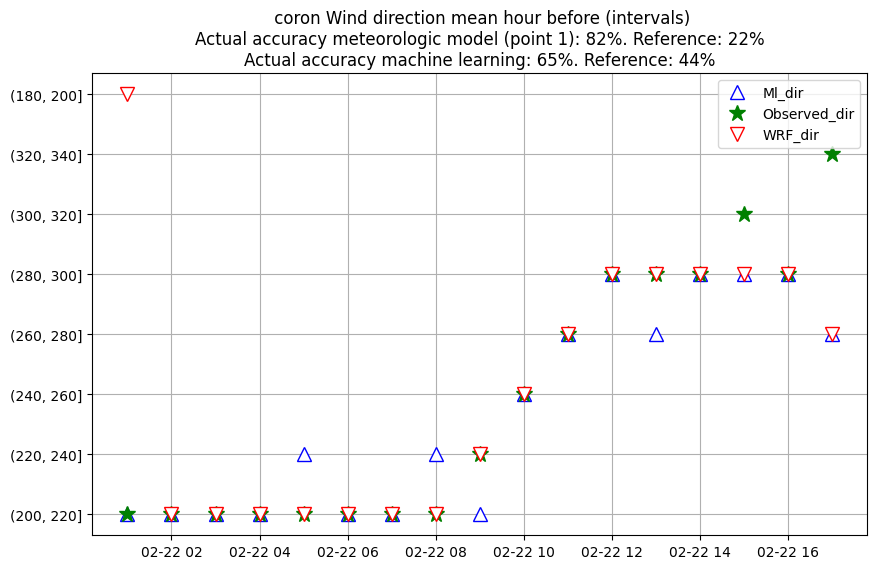

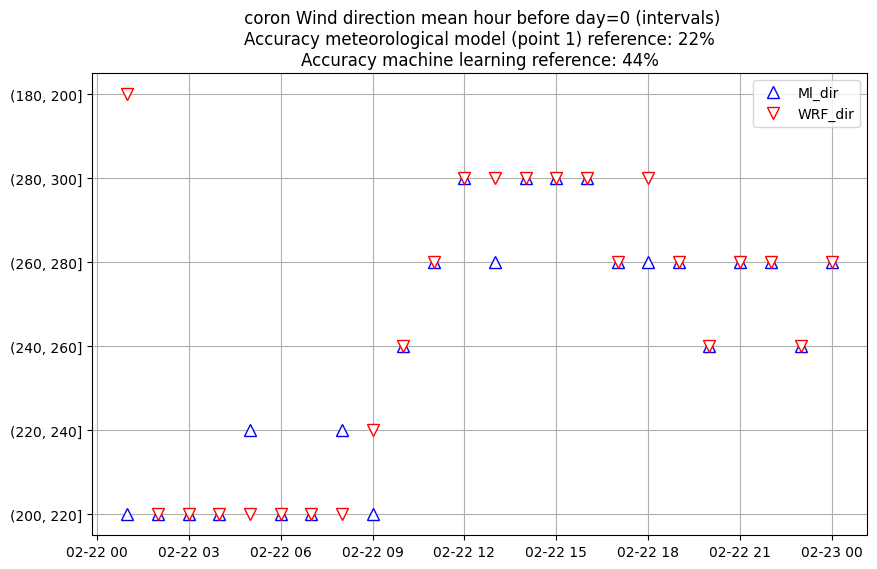

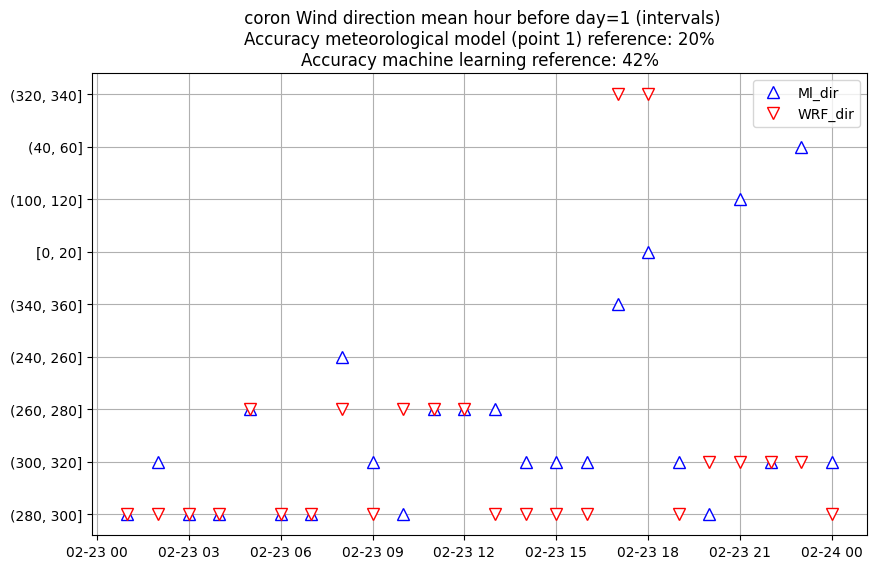

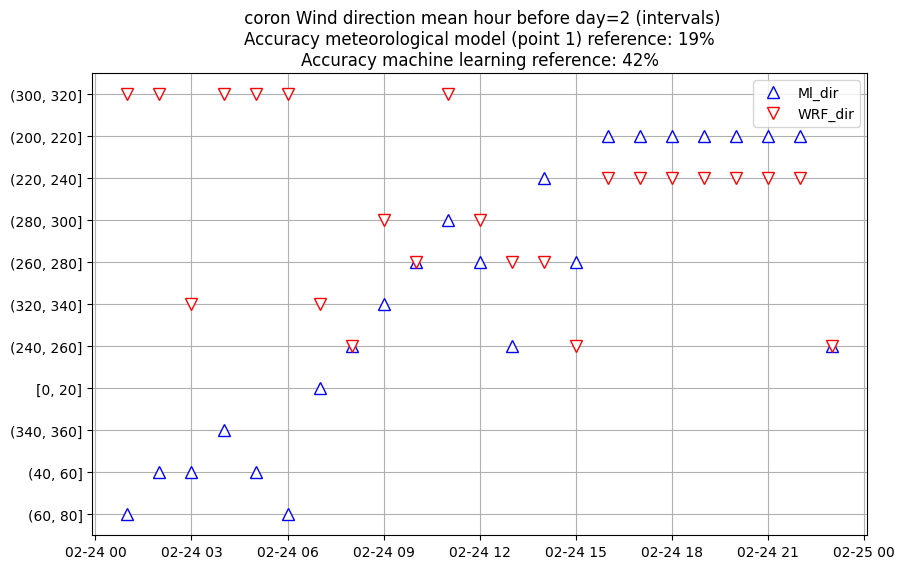

In [2]:
#@title wind direction

from sklearn.metrics import accuracy_score


#load algorithm file
algo_d0 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/dir_"+station_name+"_d0.al","rb"))
algo_d1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/dir_"+station_name+"_d1.al","rb"))
algo_d2 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/dir_"+station_name+"_d2.al","rb"))



#select x _var
model_x_var_d0 = meteo_model[:24][algo_d0["x_var"]]
model_x_var_d1 = meteo_model[24:48][algo_d1["x_var"]]
model_x_var_d2 = meteo_model[48:72][algo_d2["x_var"]]


#forecast machine learning wind direction degrees
dir_ml_d0 = algo_d0["pipe"].predict(model_x_var_d0)
dir_ml_d1 = algo_d1["pipe"].predict(model_x_var_d1)
dir_ml_d2 = algo_d2["pipe"].predict(model_x_var_d2)



#compare results
df_mod=pd.DataFrame({"time":meteo_model[:96].index,
                      "ML_dir": np.concatenate((dir_ml_d0,dir_ml_d1,dir_ml_d2),axis=0),
                      "WRF_dir1": meteo_model.dir1})
interval_d = pd.IntervalIndex.from_tuples([(-0.5,20), (20, 40), (40, 60),
                                           (60,80),(80,100),(100,120),(120,140),(140,160),
                                           (160,180),(180,200),(200,220),(220,240),
                                           (240,260),(260,280),(280,300),(300,320),
                                           (320,340),(340,360)])
labels_d = ['[0, 20]', '(20, 40]', '(40, 60]','(60, 80]', '(80, 100]',
          '(100, 120]', '(120, 140]','(140, 160]', '(160, 180]', '(180, 200]',
          '(200, 220]','(220, 240]', '(240, 260]', '(260, 280]', '(280, 300]',
          '(300, 320]', '(320, 340]', '(340, 360]']
df_mod["dir1_l"] = pd.cut(df_mod["WRF_dir1"], bins = interval_d,retbins=False,
                        labels = labels_d).map({a:b for a,b in zip(interval_d,labels_d)}).astype('category')


#get actual wind dir
r_dir = requests.get("https://servizos.meteogalicia.gal/mgrss/observacion/ultimosHorariosEstacions.action?idEst="+station_id[station_name]+"&idParam=DV_AVG_10m&numHoras=36")
json_data = json.loads(r_dir.content)

dir_o, time = [],[]
for c in json_data["listHorarios"]:
  for c1 in c['listaInstantes']:
    time.append(c1['instanteLecturaUTC'])
    dir_o.append(c1['listaMedidas'][0]["valor"])

df_st = pd.DataFrame(np.array(dir_o),columns=["dir_o"],index= time)
df_st.index = pd.to_datetime(df_st.index )

#label observed direction
df_st["dir_o_l"] = pd.cut(df_st["dir_o"], bins = interval_d,retbins=False,
                        labels = labels_d).map({a:b for a,b in zip(interval_d,labels_d)}).astype('category')


df_res = pd.concat([df_mod.set_index("time"),df_st],axis=1).dropna()
acc_ml = round(accuracy_score(df_res["dir_o_l"],df_res["ML_dir"]),2)
acc_wrf = round(accuracy_score(df_res["dir_o_l"],df_res["dir1_l"]),2)

if acc_ml < acc_wrf:
  score_wrf+=1
if acc_ml > acc_wrf:
  score_ml+=1


#labels_d = np.array(pd.Categorical(np.asarray(labels_d)))

#show results wind direction
ref_met = algo_d0["score"]["acc_met"]
ref_ml = algo_d0["score"]["acc_ml"]
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(df_res.index, df_res['ML_dir'], marker="^", color="b",markersize=10,
         markerfacecolor='w', linestyle='')
plt.plot(df_res.index, df_res['dir_o_l'], marker="*", color="g",markersize=12,
         markerfacecolor='g', linestyle='')
plt.plot(df_res.index, df_res['dir1_l'], color="r",marker="v", markersize=10,
         markerfacecolor='w', linestyle='');
plt.grid(True)
#plt.yticks(np.arange(0,len(labels_d)),labels_d)
plt.legend(('Ml_dir', 'Observed_dir',"WRF_dir"),)
plt.title(" {} Wind direction mean hour before (intervals)\nActual accuracy meteorologic model (point 1): {:.0%}. Reference: {:.0%}\nActual accuracy machine learning: {:.0%}. Reference: {:.0%}".format(station_name,acc_wrf,ref_met,acc_ml,ref_ml))
fig.show()


#forecast d0
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(df_mod["time"][:24], df_mod['ML_dir'][:24], marker="^", color="b",markersize=8,
         markerfacecolor='w', linestyle='')
plt.plot(df_mod["time"][:24], df_mod['dir1_l'][:24], color="r",marker="v", markersize=8,
         markerfacecolor='w', linestyle='');
plt.legend(('Ml_dir','WRF_dir'),)
plt.title(" {} Wind direction mean hour before day=0 (intervals)\nAccuracy meteorological model (point 1) reference: {:.0%}\nAccuracy machine learning reference: {:.0%}".format(station_name,ref_met,ref_ml))
#plt.yticks(np.arange(0,len(labels_d)-1),labels_d)
plt.grid(True, which = "both", axis = "both")
fig.show()

#forecast d1
ref_met = algo_d1["score"]["acc_met"]
ref_ml = algo_d1["score"]["acc_ml"]
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(df_mod["time"][24:48], df_mod['ML_dir'][24:48], marker="^", color="b",markersize=8,
         markerfacecolor='w', linestyle='')
plt.plot(df_mod["time"][24:48], df_mod['dir1_l'][24:48], color="r",marker="v", markersize=8,
         markerfacecolor='w', linestyle='');
plt.legend(('Ml_dir','WRF_dir'),)
plt.title(" {} Wind direction mean hour before day=1 (intervals)\nAccuracy meteorological model (point 1) reference: {:.0%}\nAccuracy machine learning reference: {:.0%}".format(station_name,ref_met,ref_ml))
#plt.yticks(np.arange(0,len(labels_d)),labels_d)
plt.grid(True, which = "both", axis = "both")
fig.show()

#forecast d2
ref_met = algo_d2["score"]["acc_met"]
ref_ml = algo_d2["score"]["acc_ml"]
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(df_mod["time"][48:72], df_mod['ML_dir'][48:72], marker="^", color="b",markersize=8,
         markerfacecolor='w', linestyle='')
plt.plot(df_mod["time"][48:72], df_mod['dir1_l'][48:72], color="r",marker="v", markersize=8,
         markerfacecolor='w', linestyle='');
plt.legend(('Ml_dir','WRF_dir'),)
plt.title(" {} Wind direction mean hour before day=2 (intervals)\nAccuracy meteorological model (point 1) reference: {:.0%}\nAccuracy machine learning reference: {:.0%}".format(station_name,ref_met,ref_ml))
#plt.yticks(np.arange(0,len(labels_d)),labels_d)
plt.grid(True, which = "both", axis = "both")
fig.show()




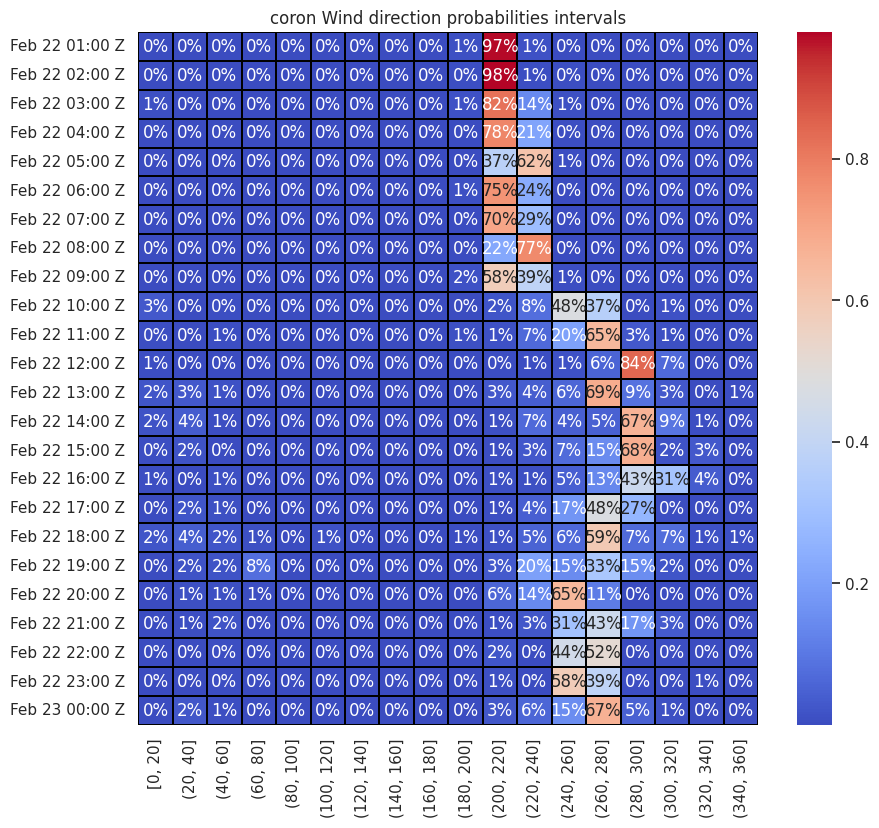

In [3]:
#@title wind direction probabilities day 0

import seaborn as sns


#probabilistic results
prob = (np.concatenate((algo_d0["pipe"].predict_proba(model_x_var_d0),
                        algo_d1["pipe"].predict_proba(model_x_var_d1),
                        algo_d2["pipe"].predict_proba(model_x_var_d2)),
                       axis =0)).transpose()
df_prob = pd.DataFrame(prob,index = (algo_d0["pipe"].classes_ )).T
df_prob = df_prob[labels_d]
df_prob.index = meteo_model[:96].index.strftime('%b %d %H:%M Z')

# Find the columns where all values are less than or equal to 5%
#cols_to_drop = df_prob[:24].columns[df_prob[:24].apply(lambda x: x <= 0.05).all()]
#df_prob.drop(cols_to_drop, axis=1, inplace=True)
df_prob[:24].columns = pd.CategoricalIndex(df_prob.columns[:24], ordered=True)
#Show results
sns.set(rc={'figure.figsize':(10,9)})
sns.heatmap(df_prob[:24], annot=True, cmap='coolwarm',
            linewidths=.05, linecolor='black',fmt='.0%')
plt.title('{} Wind direction probabilities intervals'.format(station_name))
plt.show()

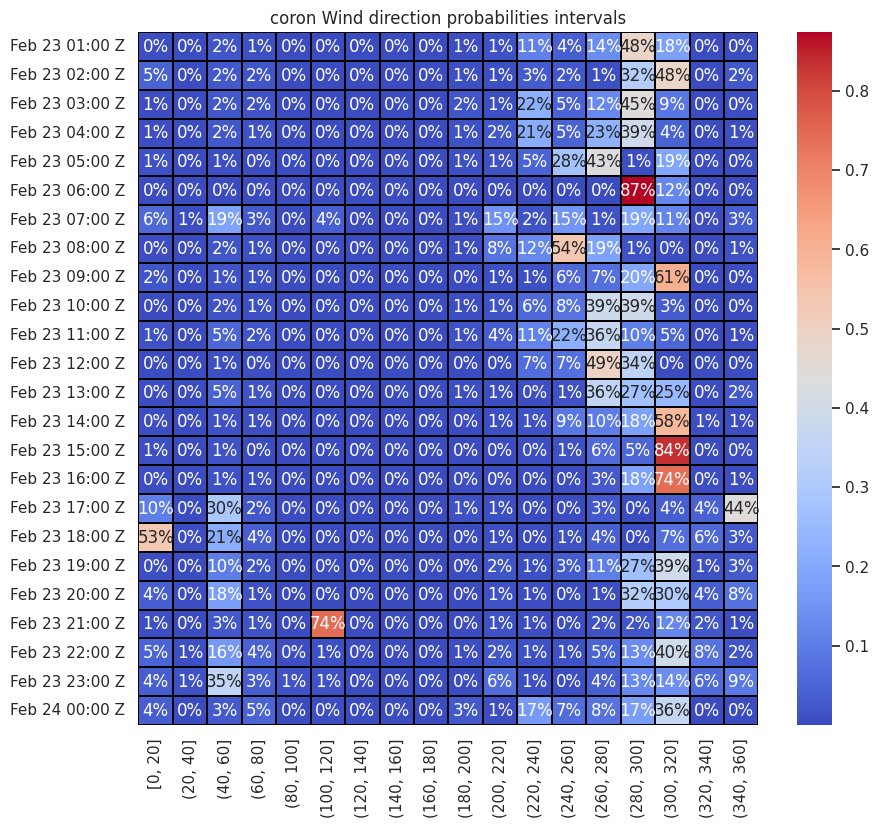

In [4]:
#@title wind direction probabilities day 1
# Find the columns where all values are less than or equal to 5%


sns.heatmap(df_prob[24:48], annot=True, cmap='coolwarm',
            linewidths=.05, linecolor='black',fmt='.0%')
plt.title('{} Wind direction probabilities intervals'.format(station_name))
plt.show()

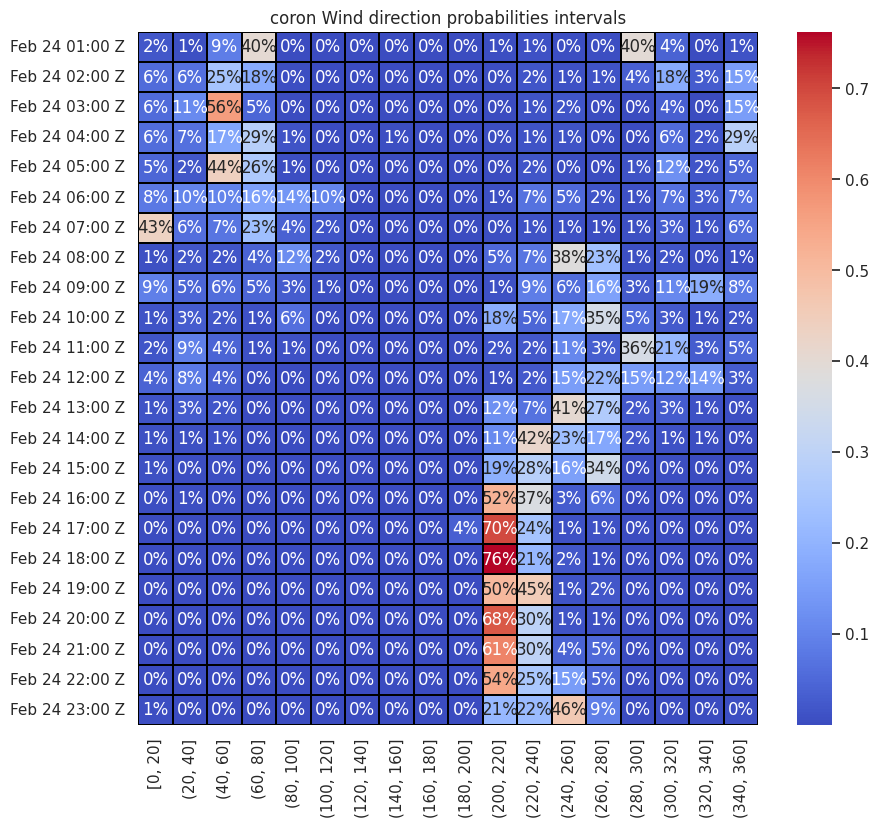

In [5]:
#@title wind direction probabilities day 2

# Find the columns where all values are less than or equal to 5%


sns.heatmap(df_prob[48:72], annot=True, cmap='coolwarm',
            linewidths=.05, linecolor='black',fmt='.0%')
plt.title('{} Wind direction probabilities intervals'.format(station_name))
plt.show()

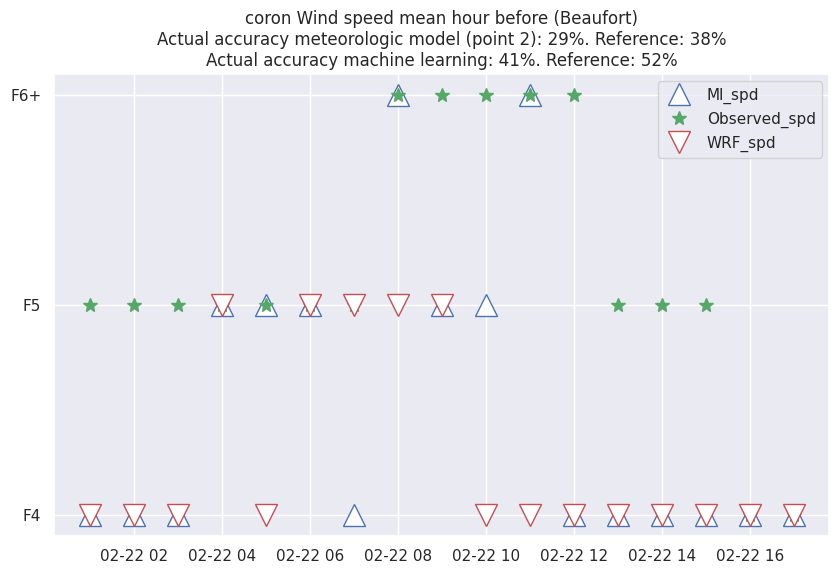

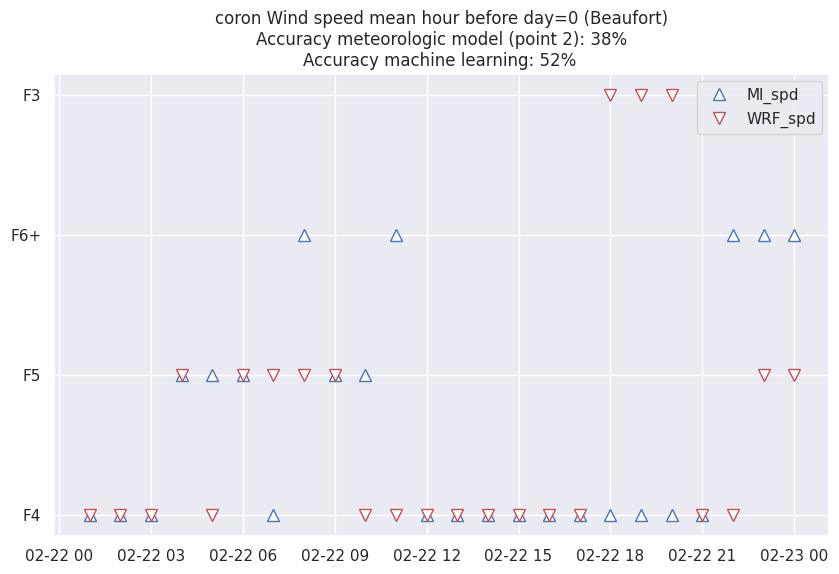

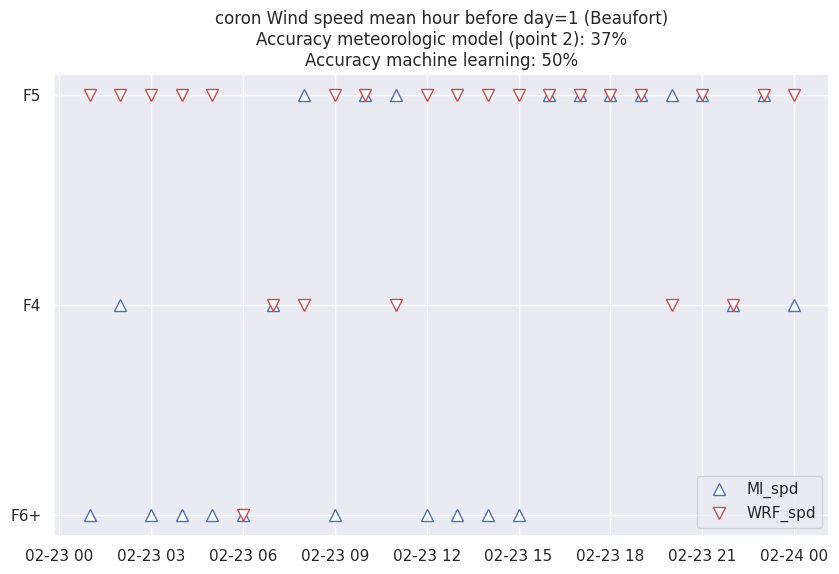

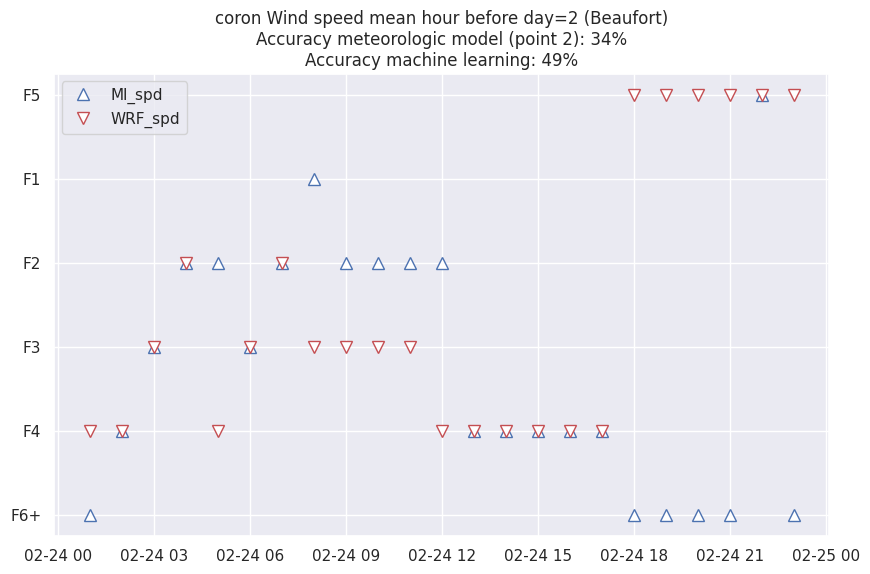

In [6]:
#@title wind speed Beaufort


#load algorithm file
algo_d0 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/spd_"+station_name+"_d0.al","rb"))
algo_d1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/spd_"+station_name+"_d1.al","rb"))
algo_d2 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/spd_"+station_name+"_d2.al","rb"))



#select x _var
model_x_var_d0 = meteo_model[:24][algo_d0["x_var"]]
model_x_var_d1 = meteo_model[24:48][algo_d1["x_var"]]
model_x_var_d2 = meteo_model[48:72][algo_d2["x_var"]]


#forecast machine learning wind speed beaufort
spd_ml_d0 = algo_d0["pipe"].predict(model_x_var_d0)
spd_ml_d1 = algo_d1["pipe"].predict(model_x_var_d1)
spd_ml_d2 = algo_d2["pipe"].predict(model_x_var_d2)



#compare results
df_mod=pd.DataFrame({"time":meteo_model[:96].index,
                      "ML_spd": np.concatenate((spd_ml_d0,spd_ml_d1,spd_ml_d2),axis=0),
                      "WRF_spd2": meteo_model.mod2})

labels = ["F0","F1","F2","F3","F4","F5","F6+"]
interval = pd.IntervalIndex.from_tuples([(-1, 0.5), (.5, 1.5), (1.5, 3.3),(3.3,5.5),
                                     (5.5,8),(8,10.7),(10.7,60)])



df_mod["spd2_l"] = pd.cut(df_mod["WRF_spd2"], bins = interval,retbins=False,
                        labels = labels).map({a:b for a,b in zip(interval,labels)}).astype('category')


#get actual wind dir
r_spd = requests.get("https://servizos.meteogalicia.gal/mgrss/observacion/ultimosHorariosEstacions.action?idEst="+station_id[station_name]+"&idParam=VV_AVG_10m&numHoras=36")
json_data = json.loads(r_spd.content)

spd_o, time = [],[]
for c in json_data["listHorarios"]:
  for c1 in c['listaInstantes']:
    time.append(c1['instanteLecturaUTC'])
    spd_o.append(c1['listaMedidas'][0]["valor"])

df_st = pd.DataFrame(np.array(spd_o),columns=["spd_o"],index= time)
df_st.index = pd.to_datetime(df_st.index )

#label observed speed
df_st["spd_o_l"] = pd.cut(df_st["spd_o"], bins = interval,retbins=False,
                        labels = labels).map({a:b for a,b in zip(interval,labels)}).astype('category')


df_res = pd.concat([df_mod.set_index("time"),df_st],axis=1).dropna()
acc_ml = round(accuracy_score(df_res["spd_o_l"],df_res["ML_spd"]),2)
acc_wrf = round(accuracy_score(df_res["spd_o_l"],df_res["spd2_l"]),2)

if acc_ml < acc_wrf:
  score_wrf+=1
if acc_ml > acc_wrf:
  score_ml+=1

#show results wind direction
ref_met = algo_d0["score"]["acc_met"]
ref_ml = algo_d0["score"]["acc_ml"]
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(df_res.index, df_res['ML_spd'], marker="^", color="b",markersize=16,
         markerfacecolor='w', linestyle='')
plt.plot(df_res.index, df_res['spd_o_l'], marker="*", color="g",markersize=10,
         markerfacecolor='g', linestyle='')
plt.plot(df_res.index, df_res['spd2_l'], color="r",marker="v", markersize=16,
         markerfacecolor='w', linestyle='');
plt.grid(True)
plt.legend(('Ml_spd', 'Observed_spd',"WRF_spd"),)
plt.title("{} Wind speed mean hour before (Beaufort)\nActual accuracy meteorologic model (point 2): {:.0%}. Reference: {:.0%}\nActual accuracy machine learning: {:.0%}. Reference: {:.0%}".format(station_name,acc_wrf,ref_met,acc_ml,ref_ml))
fig.show()


#forecast d0
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(df_mod["time"][:24], df_mod['ML_spd'][:24], marker="^", color="b",markersize=8,
         markerfacecolor='w', linestyle='')
plt.plot(df_mod["time"][:24], df_mod['spd2_l'][:24], color="r",marker="v", markersize=8,
         markerfacecolor='w', linestyle='');
plt.legend(('Ml_spd','WRF_spd'),)
plt.title("{} Wind speed mean hour before day=0 (Beaufort)\nAccuracy meteorologic model (point 2): {:.0%}\nAccuracy machine learning: {:.0%} ".format(station_name,ref_met,ref_ml))
plt.grid(True, which = "both", axis = "both")
fig.show()

#forecast d1
ref_met = algo_d1["score"]["acc_met"]
ref_ml = algo_d1["score"]["acc_ml"]
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(df_mod["time"][24:48], df_mod['ML_spd'][24:48], marker="^", color="b",markersize=8,
         markerfacecolor='w', linestyle='')
plt.plot(df_mod["time"][24:48], df_mod['spd2_l'][24:48], color="r",marker="v", markersize=8,
         markerfacecolor='w', linestyle='');
plt.legend(('Ml_spd','WRF_spd'),)
plt.title("{} Wind speed mean hour before day=1 (Beaufort)\nAccuracy meteorologic model (point 2): {:.0%}\nAccuracy machine learning: {:.0%}".format(station_name,ref_met,ref_ml))
plt.grid(True, which = "both", axis = "both")
fig.show()

#forecast d2
ref_met = algo_d2["score"]["acc_met"]
ref_ml = algo_d2["score"]["acc_ml"]
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(df_mod["time"][48:72], df_mod['ML_spd'][48:72], marker="^", color="b",markersize=8,
         markerfacecolor='w', linestyle='')
plt.plot(df_mod["time"][48:72], df_mod['spd2_l'][48:72], color="r",marker="v", markersize=8,
         markerfacecolor='w', linestyle='');
plt.legend(('Ml_spd','WRF_spd'),)
plt.title("{} Wind speed mean hour before day=2 (Beaufort)\nAccuracy meteorologic model (point 2): {:.0%}\nAccuracy machine learning: {:.0%}".format(station_name,ref_met,ref_ml))
plt.grid(True, which = "both", axis = "both")
fig.show()



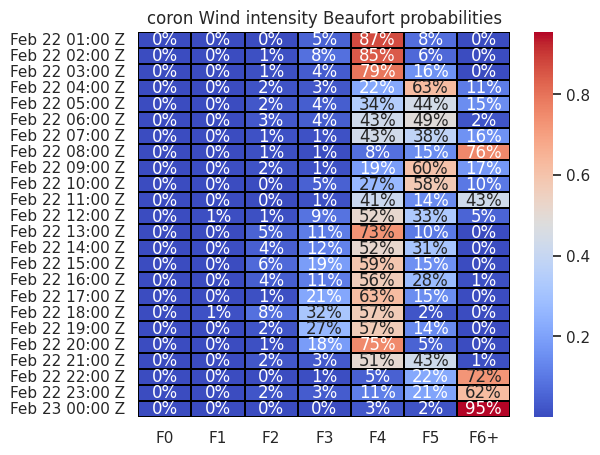

In [7]:
#@title wind speed probabilities day 0
import seaborn as sns

prob = (np.concatenate((algo_d0["pipe"].predict_proba(model_x_var_d0),
                        algo_d1["pipe"].predict_proba(model_x_var_d1),
                        algo_d2["pipe"].predict_proba(model_x_var_d2)),
                       axis =0)).transpose()
df_prob = pd.DataFrame(prob,index = (algo_d0["pipe"].classes_ )).T

df_prob.index = meteo_model[:96].index.strftime('%b %d %H:%M Z')

# Find the columns where all values are less than or equal to 5%
#cols_to_drop = df_prob[:24].columns[df_prob[:24].apply(lambda x: x <= 0.05).all()]
#df_prob.drop(cols_to_drop, axis=1, inplace=True)
sns.set(rc={'figure.figsize':(6,5)})
sns.heatmap(df_prob[:24], annot=True, cmap='coolwarm',
            linewidths=.2, linecolor='black',fmt='.0%')
plt.title('{} Wind intensity Beaufort probabilities'.format(station_name))
plt.show()

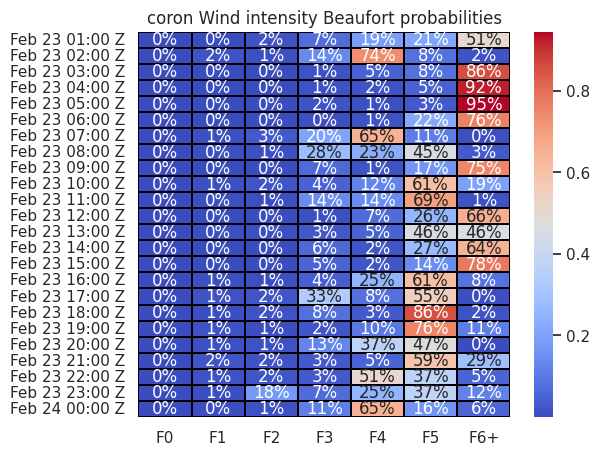

In [8]:
#@title wind speed probabilities day 1

# Find the columns where all values are less than or equal to 5%
#cols_to_drop = df_prob[24:48].columns[df_prob[24:48].apply(lambda x: x <= 0.05).all()]
#df_prob.drop(cols_to_drop, axis=1, inplace=True)

sns.heatmap(df_prob[24:48], annot=True, cmap='coolwarm',
            linewidths=.2, linecolor='black',fmt='.0%')
plt.title('{} Wind intensity Beaufort probabilities'.format(station_name))
plt.show()

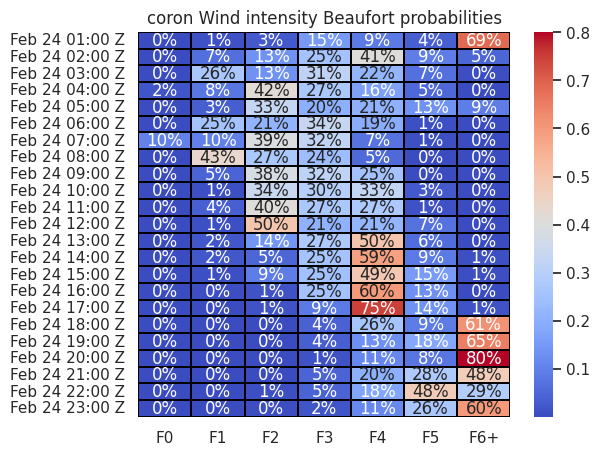

In [9]:
#@title wind speed probabilities day 2

# Find the columns where all values are less than or equal to 5%
#cols_to_drop = df_prob[48:72].columns[df_prob[48:72].apply(lambda x: x <= 0.05).all()]
#df_prob.drop(cols_to_drop, axis=1, inplace=True)

sns.heatmap(df_prob[48:72], annot=True, cmap='coolwarm',
            linewidths=.2, linecolor='black',fmt='.0%')
plt.title('{} Wind intensity Beaufort probabilities'.format(station_name))
plt.show()

In [10]:
#@title Real time

from IPython.display import clear_output
import datetime
import time

try:

  #load algorithm file gust
  algo_rdir_d0 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/rdir_"+station_name+"_d0.al","rb"))
  algo_sddir_d0 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/sddir_"+station_name+"_d0.al","rb"))
  algo_rspd_d0 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/rspd_"+station_name+"_d0.al","rb"))
  algo_sdspd_d0 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/sdspd_"+station_name+"_d0.al","rb"))


  meteo_model = get_meteogalicia_model_4Km(algo_rdir_d0["coor"])

  #add time variables
  meteo_model["hour"] = meteo_model.index.hour
  meteo_model["month"] = meteo_model.index.month
  meteo_model["dayofyear"] = meteo_model.index.dayofyear
  meteo_model["weekofyear"] = meteo_model.index.isocalendar().week.astype(int)


  #select x _var
  model_x_var_rdir = meteo_model[:24][algo_rdir_d0["x_var"]]
  model_x_var_sddir = meteo_model[:24][algo_sddir_d0["x_var"]]
  model_x_var_rspd = meteo_model[:24][algo_rspd_d0["x_var"]]
  model_x_var_sdspd = meteo_model[:24][algo_sdspd_d0["x_var"]]

  #forecast machine learning wind
  rdir = algo_rdir_d0["pipe"].predict(model_x_var_rdir)
  sddir = algo_sddir_d0["pipe"].predict(model_x_var_sddir)
  rspd = algo_rspd_d0["pipe"].predict(model_x_var_rspd)
  sdspd = algo_sdspd_d0["pipe"].predict(model_x_var_sdspd)

  instant, dir, des_dir,mod, des_mod = get_wind(station_id[station_name])
  dir_o, spd_o,time_now,dir_f,spd_f = [],[],[],[],[]

  c=0
  total_count=10
  while c<total_count:

    #Actual data
    if((datetime.datetime.utcnow()-datetime.datetime.strptime(instant, '%Y-%m-%dT%H:%M:%S')).total_seconds()/60)>15:
      instant, dir, des_dir,mod, des_mod = get_wind(station_id[station_name])

    dir_oi = abs(np.rint(np.random.normal(dir, des_dir)))
    if dir_oi> 360:
      dir_oi = dir_oi-360
    dir_o.append(dir_oi)

    spd_o.append(abs(round(np.random.normal(mod, des_mod),0)))

    time_now.append(datetime.datetime.utcnow().strftime("%H:%M:%S"))
    next_hour = (datetime.datetime.utcnow() + timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)

    #machine learning forecast
    print("")
    print("next_hour.hour-1:",next_hour.hour-1)
    dir_fi = abs(np.rint(np.random.normal(rdir[next_hour.hour-1], sddir[next_hour.hour-1])))
    if dir_fi> 360:
      dir_fi = dir_fi-360
    dir_f.append(dir_fi)
    spd_f.append(abs(np.rint(np.random.normal(rspd[next_hour.hour-1], sdspd[next_hour.hour-1])*1.94384)))

    print(f"\rtime:",time_now[-1],"dir_f:",dir_f[-1],"dir_o:",dir_o[-1],"spd_f:",spd_f[-1],"spd_o:",spd_o[-1], end='')
    c+=1
    time.sleep(2)


  df_wind = pd.DataFrame({"dir_f": dir_f,
                            "spd_f": spd_f,
                            "dir_o":dir_o,
                            "spd_o":spd_o},
                          index = time_now)

  df_wind[['dir_f',"dir_o"]].plot(grid=True,color = ["b","g"],title="time last measure: "+str(instant));
  df_wind[['spd_f',"spd_o"]].plot(grid=True,color = ["b","g"],title="time last measure: "+str(instant));

  df_re = pd.DataFrame({"rdir":rdir,"sddir":sddir,"rspd":rspd,"sdspd":sdspd})
  df_re.index=1+df_re.index

  for t in range(0,24):

    df_h = pd.DataFrame({"dir":np.random.normal(df_re['rdir'][t+1], df_re["sddir"][t+1], 10),"spd":np.random.normal(df_re['rspd'][t+1]*1.94384, df_re["sdspd"][t+1]*1.94384, 10)})


    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True);

    # Plot "dir" in the first subplot
    axes[0].plot(df_h.index, df_h["dir"], label="Direction",);
    axes[0].set_title("Time:"+str(t))
    axes[0].set_ylabel("Direction");

    # Plot "spd" in the second subplot
    axes[1].plot(df_h.index, df_h["spd"], label="Speed");
    axes[1].set_title("Time:"+str(t))
    axes[1].set_ylabel("Speed")

      # Add legend
    axes[0].legend();
    axes[1].legend();

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plots
    plt.show()

except:
  print("Wind real time simulation not available")

Output hidden; open in https://colab.research.google.com to view.

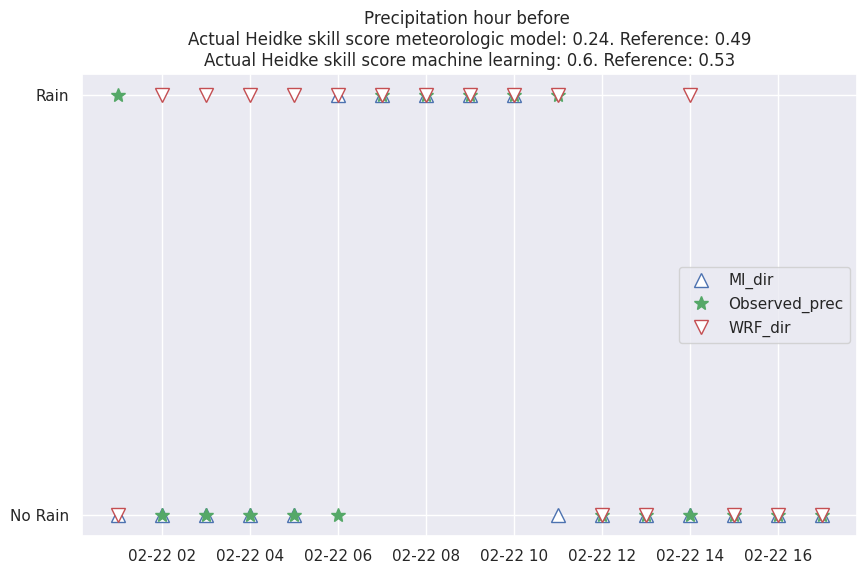

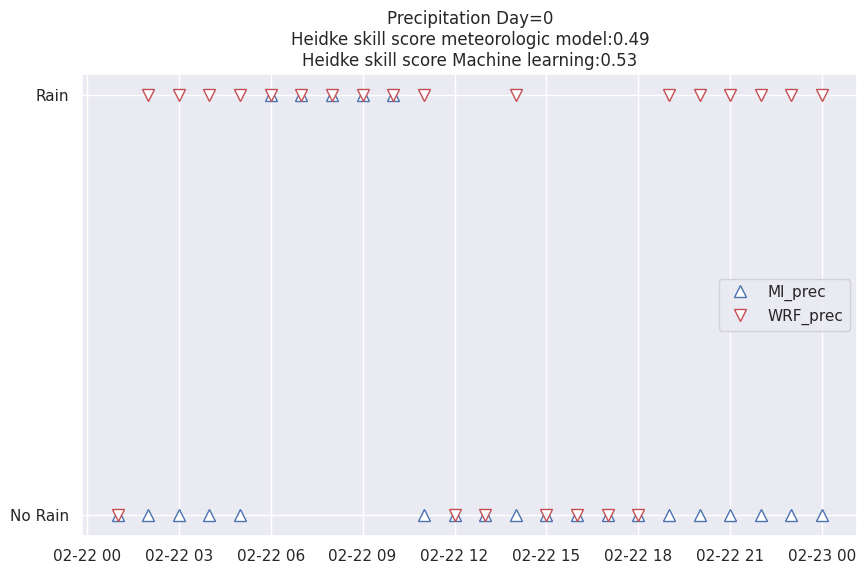

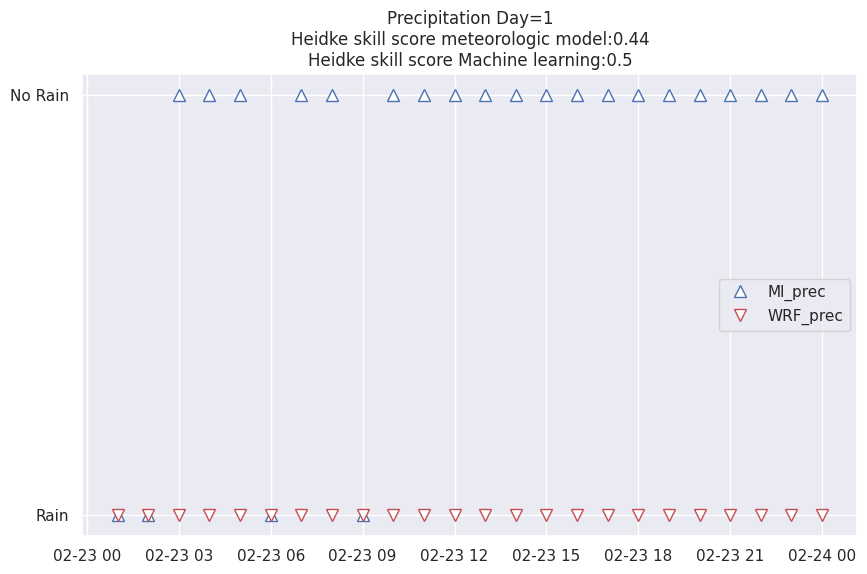

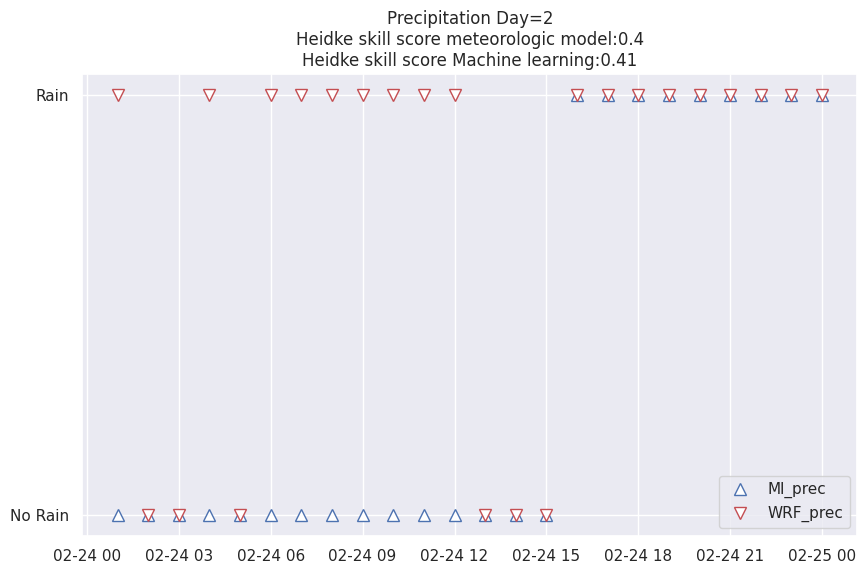

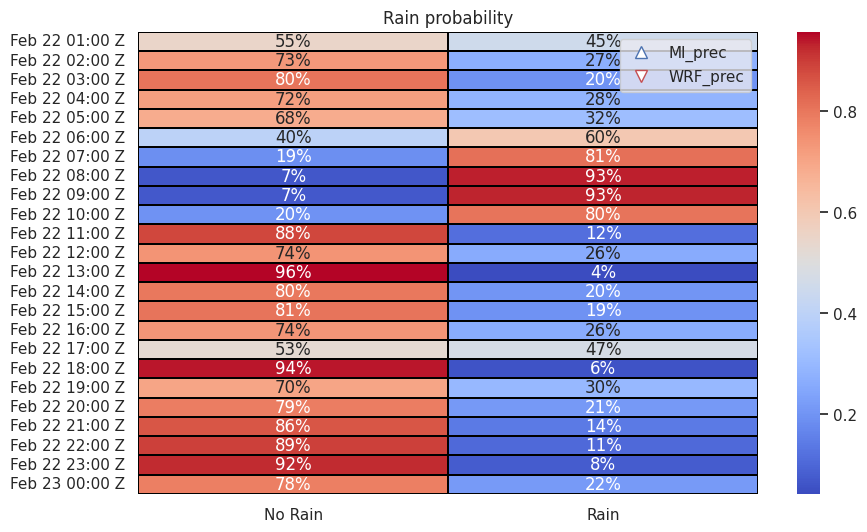

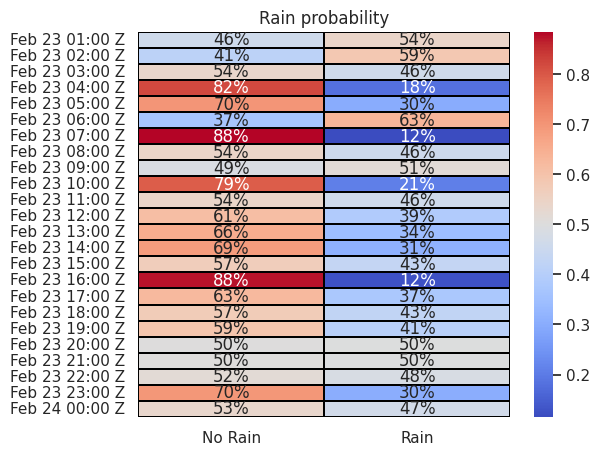

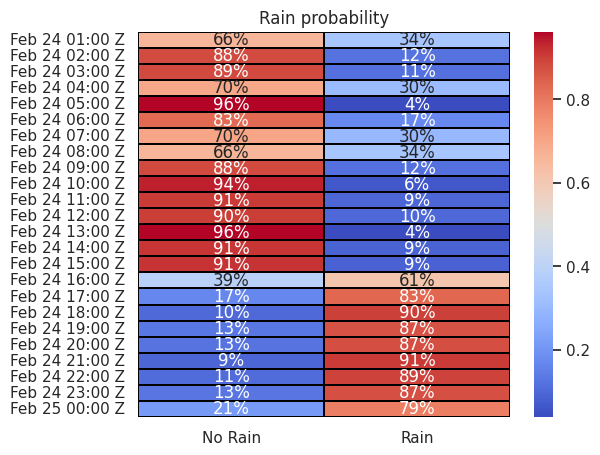

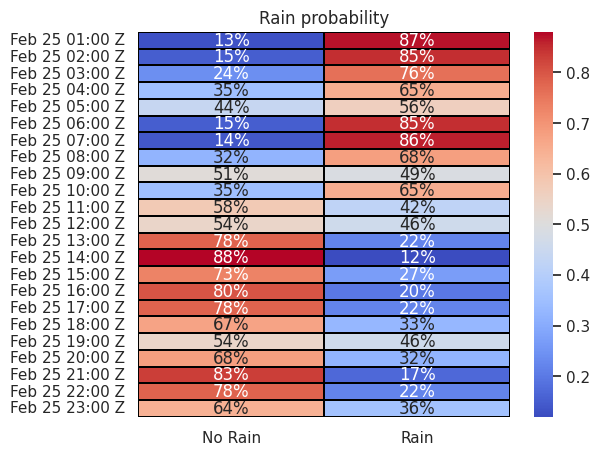

In [11]:
#@title Rain

def HSS(y_true,y_pred):
  """
  Heidke skill score if cm 2x2 table else 0
  """
  try:
    cm = pd.crosstab(y_true, y_pred)
    a = cm.values[0,0]
    b = cm.values[1,0]
    c = cm.values[0,1]
    d = cm.values[1,1]
    hss = 2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d))
  except:
    hss = 0
  return round(hss,2)

try:

  #load algorithm file
  algo_d0 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/prec_"+station_name+"_d0.al","rb"))
  algo_d1 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/prec_"+station_name+"_d1.al","rb"))
  algo_d2 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/prec_"+station_name+"_d2.al","rb"))
  algo_d3 = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/Pontevedra_Ria/"+station_name+"/algorithms/prec_"+station_name+"_d3.al","rb"))


  #select x _var
  model_x_var_d0 = meteo_model[:24][algo_d0["x_var"]]
  model_x_var_d1 = meteo_model[24:48][algo_d1["x_var"]]
  model_x_var_d2 = meteo_model[48:72][algo_d2["x_var"]]
  model_x_var_d3 = meteo_model[72:96][algo_d3["x_var"]]

  #forecast machine learning wind direction degrees
  prec_ml_d0 = algo_d0["pipe"].predict(model_x_var_d0)
  prec_ml_d1 = algo_d1["pipe"].predict(model_x_var_d1)
  prec_ml_d2 = algo_d2["pipe"].predict(model_x_var_d2)
  prec_ml_d3 = algo_d3["pipe"].predict(model_x_var_d3)


  #compare results
  df_mod=pd.DataFrame({"time":meteo_model[:96].index,
                        "ML_prec": np.concatenate((prec_ml_d0,prec_ml_d1,prec_ml_d2,prec_ml_d3),axis=0),
                        "WRF_prec0": meteo_model.prec0})
  interval_d = pd.IntervalIndex.from_tuples([(-0.5,0.1), (0.1, 100)])
  labels_d = ['No Rain', 'Rain']
  df_mod["prec0_l"] = pd.cut(df_mod["WRF_prec0"], bins = interval_d,retbins=False,
                          labels = labels_d).map({a:b for a,b in zip(interval_d,labels_d)}).astype('category')


  #get actual wind dir
  r_prec = requests.get("https://servizos.meteogalicia.gal/mgrss/observacion/ultimosHorariosEstacions.action?idEst="+station_id[station_name]+"&idParam=PP_SUM_1.5m&numHoras=36")
  json_data = json.loads(r_prec.content)

  prec_o, time = [],[]
  for c in json_data["listHorarios"]:
    for c1 in c['listaInstantes']:
      time.append(c1['instanteLecturaUTC'])
      prec_o.append(c1['listaMedidas'][0]["valor"])

  df_st = pd.DataFrame(np.array(prec_o),columns=["prec_o"],index= time)
  df_st.index = pd.to_datetime(df_st.index )

  #label observed direction
  df_st["prec_o_l"] = pd.cut(df_st["prec_o"], bins = interval_d,retbins=False,
                          labels = labels_d).map({a:b for a,b in zip(interval_d,labels_d)}).astype('category')


  df_res = pd.concat([df_mod.set_index("time"),df_st],axis=1).dropna()
  hss_ml = HSS(df_res.prec_o_l,df_res.ML_prec)
  hss_wrf = HSS(df_res.prec_o_l,df_res.prec0_l)

  if hss_ml < hss_wrf:
    score_wrf+=1
  if hss_ml > hss_wrf:
    score_ml+=1


  labels_d = np.array(pd.Categorical(np.asarray(labels_d)))

  #show results
  ref_met = algo_d0["score"]["hss_met"]
  ref_ml = algo_d0["score"]["hss_ml"]
  fig, ax = plt.subplots(figsize=(10,6))
  plt.plot(df_res.index, df_res['ML_prec'], marker="^", color="b",markersize=10,
          markerfacecolor='w', linestyle='')
  plt.plot(df_res.index, df_res['prec_o_l'], marker="*", color="g",markersize=10,
          markerfacecolor='g', linestyle='')
  plt.plot(df_res.index, df_res['prec0_l'], color="r",marker="v", markersize=10,
          markerfacecolor='w', linestyle='');
  plt.grid(True)
  plt.legend(('Ml_dir', 'Observed_prec',"WRF_dir"),)
  plt.title("Precipitation hour before \nActual Heidke skill score meteorologic model: {}. Reference: {}\nActual Heidke skill score machine learning: {}. Reference: {}".format(hss_wrf,ref_met,hss_ml,ref_ml))
  fig.show()


  #forecast d0
  fig, ax = plt.subplots(figsize=(10,6))
  plt.plot(df_mod["time"][:24], df_mod['ML_prec'][:24], marker="^", color="b",markersize=8,
          markerfacecolor='w', linestyle='')
  plt.plot(df_mod["time"][:24], df_mod['prec0_l'][:24], color="r",marker="v", markersize=8,
          markerfacecolor='w', linestyle='');
  plt.legend(('Ml_prec','WRF_prec'),)
  plt.title("Precipitation Day=0\nHeidke skill score meteorologic model:{}\nHeidke skill score Machine learning:{}".format(ref_met,ref_ml))
  #plt.yticks(np.arange(0,len(labels_d)-1),labels_d)
  plt.grid(True, which = "both", axis = "both")
  fig.show()

  #forecast d1
  ref_met = algo_d1["score"]["hss_met"]
  ref_ml = algo_d1["score"]["hss_ml"]
  fig, ax = plt.subplots(figsize=(10,6))
  plt.plot(df_mod["time"][24:48], df_mod['ML_prec'][24:48], marker="^", color="b",markersize=8,
          markerfacecolor='w', linestyle='')
  plt.plot(df_mod["time"][24:48], df_mod['prec0_l'][24:48], color="r",marker="v", markersize=8,
          markerfacecolor='w', linestyle='');
  plt.legend(('Ml_prec','WRF_prec'),)
  plt.title("Precipitation Day=1\nHeidke skill score meteorologic model:{}\nHeidke skill score Machine learning:{}".format(ref_met,ref_ml))
  #plt.yticks(np.arange(0,len(labels_d)),labels_d)
  plt.grid(True, which = "both", axis = "both")
  fig.show()

  #forecast d2
  ref_met = algo_d2["score"]["hss_met"]
  ref_ml = algo_d2["score"]["hss_ml"]
  fig, ax = plt.subplots(figsize=(10,6))
  plt.plot(df_mod["time"][48:72], df_mod['ML_prec'][48:72], marker="^", color="b",markersize=8,
          markerfacecolor='w', linestyle='')
  plt.plot(df_mod["time"][48:72], df_mod['prec0_l'][48:72], color="r",marker="v", markersize=8,
          markerfacecolor='w', linestyle='');
  plt.legend(('Ml_prec','WRF_prec'),)
  plt.title("Precipitation Day=2\nHeidke skill score meteorologic model:{}\nHeidke skill score Machine learning:{}".format(ref_met,ref_ml))
  #plt.yticks(np.arange(0,len(labels_d)),labels_d)
  plt.grid(True, which = "both", axis = "both")
  fig.show()

  #forecast d3
  ref_met = algo_d3["score"]["hss_met"]
  ref_ml = algo_d3["score"]["hss_ml"]
  fig, ax = plt.subplots(figsize=(10,6))
  plt.plot(df_mod["time"][72:96], df_mod['ML_prec'][72:96], marker="^", color="b",markersize=8,
          markerfacecolor='w', linestyle='')
  plt.plot(df_mod["time"][72:96], df_mod['prec0_l'][72:96], color="r",marker="v", markersize=8,
          markerfacecolor='w', linestyle='');
  plt.legend(('Ml_prec','WRF_prec'),)
  plt.title("Precipitation Day=3\nHeidke skill score meteorologic model:{}\nHeidke skill score Machine learning:{}".format(ref_met,ref_ml))
  #plt.yticks(np.arange(0,len(labels_d)),labels_d)
  plt.grid(True, which = "both", axis = "both")
  fig.show()

  prob = (np.concatenate((algo_d0["pipe"].predict_proba(model_x_var_d0),
                        algo_d1["pipe"].predict_proba(model_x_var_d1),
                        algo_d2["pipe"].predict_proba(model_x_var_d2),
                        algo_d3["pipe"].predict_proba(model_x_var_d3)),
                       axis =0)).transpose()
  df_prob = pd.DataFrame(prob,index = (algo_d0["pipe"].classes_ )).T

  df_prob.index = meteo_model[:96].index.strftime('%b %d %H:%M Z')

  #sns.set(rc={'figure.figsize':(2,6)})
  sns.heatmap(df_prob[:24], annot=True, cmap='coolwarm',
              linewidths=.2, linecolor='black',fmt='.0%')
  plt.title('Rain probability')
  plt.show()

  sns.heatmap(df_prob[24:48], annot=True, cmap='coolwarm',
            linewidths=.2, linecolor='black',fmt='.0%')
  plt.title('Rain probability')
  plt.show()

  sns.heatmap(df_prob[48:72], annot=True, cmap='coolwarm',
            linewidths=.2, linecolor='black',fmt='.0%')
  plt.title('Rain probability')
  plt.show()

  sns.heatmap(df_prob[72:96], annot=True, cmap='coolwarm',
            linewidths=.2, linecolor='black',fmt='.0%')
  plt.title('Rain probability')
  plt.show()

except:
  print("Rain forecast not available")